# 查看工具调用

!!!提示“先决条件”

本指南假设您熟悉以下概念：

* [工具调用](https://js.langchain.com/docs/concepts/tool_calling/)
* [人在循环](/langgraphjs/concepts/ human_in_the_loop)
* [LangGraph 术语表](/langgraphjs/concepts/low_level)

人机回路（HIL）交互对于代理系统至关重要（https://langchain-ai.github.io/langgraphjs/concepts/agentic_concepts/# human-in-the-loop）。一种常见的模式是在某些工具调用之后在循环步骤中添加一些人员。这些工具调用通常会导致函数调用或保存某些信息。示例包括：

- 执行 SQL 的工具调用，然后由该工具运行
- 调用工具来生成摘要，然后将其保存到图形的状态中

请注意，使用工具调用很常见**无论是否实际调用工具**。

您通常可能想要在此处进行一些不同的交互：

1. 批准工具调用并继续
2.手动修改工具调用然后继续
3. 提供自然语言反馈，然后将其传递回代理而不是继续

我们可以使用 [`interrupt()`](/langgraphjs/reference/functions/langgraph.interrupt-1.html) 函数在 LangGraph 中实现这些。`interrupt` 允许我们停止图形执行以收集用户的输入并使用收集的输入继续执行：
```typescript
function humanReviewNode(state: typeof GraphAnnotation.State) {
  // this is the value we'll be providing via new Command({ resume: <human_review> })
  const humanReview = interrupt({
    question: "Is this correct?",
    // Surface tool calls for review
    tool_call,
  });

  const [reviewAction, reviewData] = humanReview;

  // Approve the tool call and continue
  if (reviewAction === "continue") {
    return new Command({ goto: "run_tool" });
  }
  
  // Modify the tool call manually and then continue
  if (reviewAction === "update") {
    const updatedMsg = getUpdatedMsg(reviewData);
    return new Command({ goto: "run_tool", update: { messages: [updatedMsg] } });
  }
  
  // Give natural language feedback, and then pass that back to the agent
  if (reviewAction === "feedback") {
    const feedbackMsg = getFeedbackMsg(reviewData);
    return new Command({ goto: "call_llm", update: { messages: [feedbackMsg] } });
  }
  
  throw new Error("Unreachable");
}
```


## 设置

首先我们需要安装需要的包
```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core
```
接下来，我们需要为 Anthropic 设置 API 密钥（我们将使用的 LLM）
```bash
export ANTHROPIC_API_KEY=your-api-key
```
或者，我们可以为 [LangSmith 追踪](https://smith.langchain.com/) 设置 API 密钥，这将为我们提供一流的可观察性。
```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## 简单用法

让我们设置一个非常简单的图表来促进这一点。
首先，我们将召开法学硕士电话会议，决定采取什么行动。
然后我们进入一个人类节点。该节点实际上不执行任何操作 - 我们的想法是我们在此节点之前中断，然后对状态应用任何更新。
之后，我们检查状态并路由回 LLM 或正确的工具。

让我们看看实际效果！

In [14]:
import {
  MessagesAnnotation,
  StateGraph,
  START,
  END,
  MemorySaver,
  Command,
  interrupt
} from "@langchain/langgraph";
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from '@langchain/core/tools';
import { z } from 'zod';
import { AIMessage, ToolMessage } from '@langchain/core/messages';
import { ToolCall } from '@langchain/core/messages/tool';

const weatherSearch = tool((input: { city: string }) => {
    console.log("----");
    console.log(`Searching for: ${input.city}`);
    console.log("----");
    return "Sunny!";
}, {
    name: 'weather_search',
    description: 'Search for the weather',
    schema: z.object({
        city: z.string()
    })
});

const model = new ChatAnthropic({ 
    model: "claude-3-5-sonnet-latest"
}).bindTools([weatherSearch]);

const callLLM = async (state: typeof MessagesAnnotation.State) => {
    const response = await model.invoke(state.messages);
    return { messages: [response] };
};

const humanReviewNode = async (state: typeof MessagesAnnotation.State): Promise<Command> => {
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    const toolCall = lastMessage.tool_calls![lastMessage.tool_calls!.length - 1];

    const humanReview = interrupt<
      {
        question: string;
        toolCall: ToolCall;
      },
      {
        action: string;
        data: any;
      }>({
        question: "Is this correct?",
        toolCall: toolCall
      });

    const reviewAction = humanReview.action;
    const reviewData = humanReview.data;

    if (reviewAction === "continue") {
        return new Command({ goto: "run_tool" });
    }
    else if (reviewAction === "update") {
        const updatedMessage = {
            role: "ai",
            content: lastMessage.content,
            tool_calls: [{
                id: toolCall.id,
                name: toolCall.name,
                args: reviewData
            }],
            id: lastMessage.id
        };
        return new Command({ goto: "run_tool", update: { messages: [updatedMessage] } });
    }
    else if (reviewAction === "feedback") {
        const toolMessage = new ToolMessage({
          name: toolCall.name,
          content: reviewData,
          tool_call_id: toolCall.id
        })
        return new Command({ goto: "call_llm", update: { messages: [toolMessage] }});
    }
    throw new Error("Invalid review action");
};

const runTool = async (state: typeof MessagesAnnotation.State) => {
    const newMessages: ToolMessage[] = [];
    const tools = { weather_search: weatherSearch };
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    const toolCalls = lastMessage.tool_calls!;

    for (const toolCall of toolCalls) {
        const tool = tools[toolCall.name as keyof typeof tools];
        const result = await tool.invoke(toolCall.args);
        newMessages.push(new ToolMessage({
            name: toolCall.name,
            content: result,
            tool_call_id: toolCall.id
        }));
    }
    return { messages: newMessages };
};

const routeAfterLLM = (state: typeof MessagesAnnotation.State): typeof END | "human_review_node" => {
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    if (!lastMessage.tool_calls?.length) {
        return END;
    }
    return "human_review_node";
};

const workflow = new StateGraph(MessagesAnnotation)
    .addNode("call_llm", callLLM)
    .addNode("run_tool", runTool)
    .addNode("human_review_node", humanReviewNode, {
      ends: ["run_tool", "call_llm"]
    })
    .addEdge(START, "call_llm")
    .addConditionalEdges(
        "call_llm",
        routeAfterLLM,
        ["human_review_node", END]
    )
    .addEdge("run_tool", "call_llm");

const memory = new MemorySaver();

const graph = workflow.compile({ checkpointer: memory });

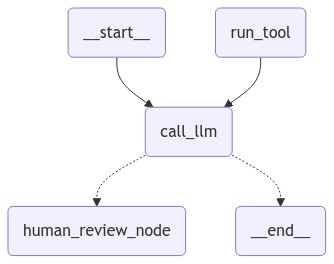

In [15]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## 没有评论的示例

我们看一个不需要review的例子（因为没有调用任何工具）

In [16]:
let inputs = { messages: [{ role: "user", content: "hi!" }] };
let config = { configurable: { thread_id: "1" }, streamMode: "values" as const };

let stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
hi!
================================ ai Message (1) =================================
Hello! I'm here to help you. I can assist you with checking the weather for different cities. Would you like to know the weather for a specific location? Just let me know which city you're interested in and I'll look that up for you.


如果我们检查状态，我们可以看到它已完成，因为没有后续步骤需要执行：

In [17]:
let state = await graph.getState(config);
console.log(state.next);

[]


## 审批工具示例

现在让我们看看批准工具调用是什么样子的

In [18]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "2" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01PTn9oqTP6EdFabfhfvELuy',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]


如果我们现在检查，我们可以看到它正在等待人工审核

In [19]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


要批准工具调用，我们可以直接继续线程而不进行任何编辑。为此，我们需要让 `human_review_node` 知道我们在节点内定义的 `human_review` 变量使用什么值。我们可以通过使用 `new Command({ resume: <human_review> })` 输入调用图形来提供该值。由于我们正在批准工具调用，因此我们将提供 `{ action: "continue" }` 的 `resume` 值以导航到 `run_tool` 节点：

In [20]:
import { Command } from "@langchain/langgraph";

for await (const event of await graph.stream(
  new Command({ resume: { action: "continue" } }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}

================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01PTn9oqTP6EdFabfhfvELuy',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
----
Searching for: San Francisco
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
It's sunny in San Francisco right now!


## 编辑工具调用

现在假设我们要编辑工具调用。例如。更改一些参数（甚至调用的工具！），然后执行该工具。

In [21]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "3" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]


如果我们现在检查，我们可以看到它正在等待人工审核

In [22]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


要编辑工具调用，我们将使用 `Command` 和不同的恢复值 `{ action: "update", data: <tool call args> }`。这将执行以下操作：

* 将现有工具调用与用户提供的工具调用参数相结合，并使用新工具调用更新现有 AI 消息
* 导航到包含更新的 AI 消息的 `run_tool` 节点并继续执行

In [23]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "update",
      data: { city: "San Francisco" }
    }
  }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}


================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
----
Searching for: San Francisco
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
It's sunny in San Francisco right now!


## 向工具调用提供反馈

有时，您可能不想执行工具调用，但也可能不想要求用户手动修改工具调用。在这种情况下，从用户那里获得自然语言反馈可能会更好。然后，您可以将这些反馈作为工具调用的模拟 **RESULT** 插入。

有多种方法可以做到这一点：

1.您可以向状态添加一条新消息（表示工具调用的“结果”）
2. 您可以向状态添加两条新消息 - 一条代表工具调用中的“错误”，另一条代表反馈的 HumanMessage

两者的相似之处在于它们都涉及向状态添加消息。主要区别在于 `human_node` 之后的逻辑以及它如何处理不同类型的消息。

对于此示例，我们将仅添加一个代表反馈的工具调用。让我们看看实际效果！

In [24]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "4" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "I'll help you check the weather in San Francisco."
  },
  {
    type: 'tool_use',
    id: 'toolu_014cwxD65wDwQdNg6xqsticF',
    name: 'weather_search',
    input: { city: 'SF' }
  }
]


如果我们现在检查，我们可以看到它正在等待人工审核

In [25]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


为了提供有关工具调用的反馈，我们将使用 `Command` 和不同的恢复值 `{ action: "feedback", data: <feedback string> }`。这将执行以下操作：

* 创建一条新的工具消息，将 LLM 的现有工具调用与用户提供的反馈作为内容相结合
* 使用更新的工具消息导航到 `call_llm` 节点并继续执行

In [26]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "feedback",
      data: "User requested changes: use <city, country> format for location"
    }
  }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}


================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "I'll help you check the weather in San Francisco."
  },
  {
    type: 'tool_use',
    id: 'toolu_014cwxD65wDwQdNg6xqsticF',
    name: 'weather_search',
    input: { city: 'SF' }
  }
]
================================ tool Message (1) =================================
User requested changes: use <city, country> format for location
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the error. Let me search again with the proper format.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Jnm7sSZsiwv65YM4KsvfXk',
    name: 'weather_search',
    input: { city: 'San Francisco, USA' }
  }
]


我们可以看到我们现在到达了另一个断点 - 因为它返回到模型并得到了关于调用内容的全新预测。现在让我们批准这一点并继续。

In [27]:
state = await graph.getState(config);
console.log(state.next);


[ 'human_review_node' ]


In [28]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "continue",
    }
  }),
  config
)) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the error. Let me search again with the proper format.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Jnm7sSZsiwv65YM4KsvfXk',
    name: 'weather_search',
    input: { city: 'San Francisco, USA' }
  }
]
----
Searching for: San Francisco, USA
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
The weather in San Francisco is currently sunny!
